In [8]:
import snowflake.connector
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

In [16]:
with open("snowflake_password.txt", "r") as file:
    snowflake_password = file.read()
    snowflake_password = snowflake_password.strip()

In [17]:
conn = snowflake.connector.connect(
    user='YCHAUDHARI',
    password=snowflake_password,
    account='TQ19230.us-central1.gcp'
)

# Create cursor object instance
cursor = conn.cursor()

#### Q3: Install DBT using Miniconda (0.5 points)

In [1]:
!which dbt

/home/ysc150799/miniconda3/envs/p4-env/bin/dbt


#### Q9: Use dbt to transform the column names to single word or two-word names with "_" separator and create a view named `transform_survey`. (4 points)

In [2]:
!cat ~/.dbt/profiles.yml | grep -v password

p4_data_pipeline:
  target: dev
  outputs:
    dev:
      type: snowflake
      account: TQ19230.us-central1.gcp
      user: YCHAUDHARI
      role: P4_ROLE
      database: SURVEY_DATABASE
      warehouse: P4_WAREHOUSE
      schema: SURVEY_SCHEMA
      threads: 1
      client_session_keep_alive: False

  target: stock_db
  outputs:
    stock_db:
      type: snowflake
      account: TQ19230.us-central1.gcp
      user: YCHAUDHARI
      role: P4_ROLE
      database: STOCK_DB
      warehouse: P4_WAREHOUSE
      schema: STOCK_SCHEMA
      threads: 1
      client_session_keep_alive: false


In [3]:
!cat ../p4_data_pipeline/models/schema.yml

version: 2

sources:
  - name: p4_survey_data
    database: SURVEY_DATABASE
    schema: SURVEY_SCHEMA
    tables:
      - name: survey  # original table from Google Sheets

  - name: stock_by_day
    database: STOCK_DB
    schema: STOCK_SCHEMA
    tables:
      - name: US_STOCK_METRICS

  - name: fx_by_day
    database: STOCK_DB
    schema: STOCK_SCHEMA
    tables:
      - name: FOREX_METRICS

  - name: airbyte_csv_data
    database: STOCK_DB
    schema: STOCK_SCHEMA
    tables:
      - name: TRADING_BOOKS
      - name: WEIGHTS_TABLE


In [4]:
!cat ../p4_data_pipeline/models/staging/transform_survey.sql

with raw_survey as (
    select * from {{ source('p4_survey_data', 'survey') }}
),

transform_survey as (
    select
        {{ adapter.quote('EMAIL_ADDRESS') }} as email,
        {{ adapter.quote('WHAT_IS_YOUR_AGE_') }} as age,
        {{ adapter.quote('WHICH_BEST_DESCRIBES_YOUR_PRIMARY_MAJOR_OR_FIELD_OF_STUDY_IF_YOU_HAVE_MORE_THAN_ONE_MAJOR_PLEASE_SPECIFY_OTHER_MAJORS_AS_PART_OF_THE_NEXT_QUESTION_') }} as primary_major,
	{{ adapter.quote('IF_YOU_HAVE_SECONDARY_MAJORS_PLEASE_LIST_THEM_HERE_SEPARATED_BY_A_COMMA_') }} as secondary_major,
	{{ adapter.quote('WHAT_FACTOR_INFLUENCES_YOUR_COURSE_SELECTION_THE_MOST_') }} as course_influence,
	{{ adapter.quote('WHAT_IS_THE_5_DIGIT_ZIP_CODE_OF_YOUR_RESIDENCE_WHILE_ATTENDING_CLASSES_IF_YOU_ARE_NOT_SURE_CHECK_HERE_HTTPS_TOOLS_USPS_COM_ZIP_CODE_LOOKUP_HTM_BYADDRESS_') }} as zip_code,
	{{ adapter.quote('WHAT_IS_YOUR_FAVORITE_PIZZA_TOPPING_') }} as favorite_topping,
	{{ adapter.quote('HAVE_YOU_EVER_IN_YOUR_LIFE_HAD_A_PET_') }} as has_pet,
	{{ adapte

#### Q10: What percentage of Student have Reading or Watching Something as their hobby

In [21]:
cursor.execute("USE DATABASE SURVEY_DATABASE;")
cursor.execute("USE SCHEMA SURVEY_SCHEMA;")

df = pd.read_sql("""
WITH Interested_Hobby_Count AS
(
SELECT COUNT(*) AS stud_cnt
FROM TRANSFORM_SURVEY
WHERE LOWER(FAVORITE_HOBBY) = 'reading'
OR LOWER(FAVORITE_HOBBY) LIKE '%watching%'
)
SELECT ROUND(stud_cnt * 100.0 / (SELECT COUNT(*) FROM TRANSFORM_SURVEY),2) AS per_of_student
FROM Interested_Hobby_Count
""", conn)
df

/tmp/ipykernel_1873960/2676212306.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("""


,PER_OF_STUDENT
0,13.84


So Approx 14% of students have hobby as reading or watching some series or movies

#### Q11: How is the distribution of primary major in course CS639? Also draw a plot to show

In [26]:
df = pd.read_sql("""
SELECT PRIMARY_MAJOR, COUNT(*) as No_of_students
FROM TRANSFORM_SURVEY
GROUP BY PRIMARY_MAJOR
""", conn)
df

/tmp/ipykernel_1873960/3942198682.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("""


,PRIMARY_MAJOR,NO_OF_STUDENTS
0,Computer Science,76
1,Business: Actuarial,1
2,Data Science,69
3,Other,1
4,Engineering: Other,2
5,Mathematics/AMEP,4
6,Science: Physics,2
7,Business: Information Systems,1
8,Statistics,2
9,Business: Other,1


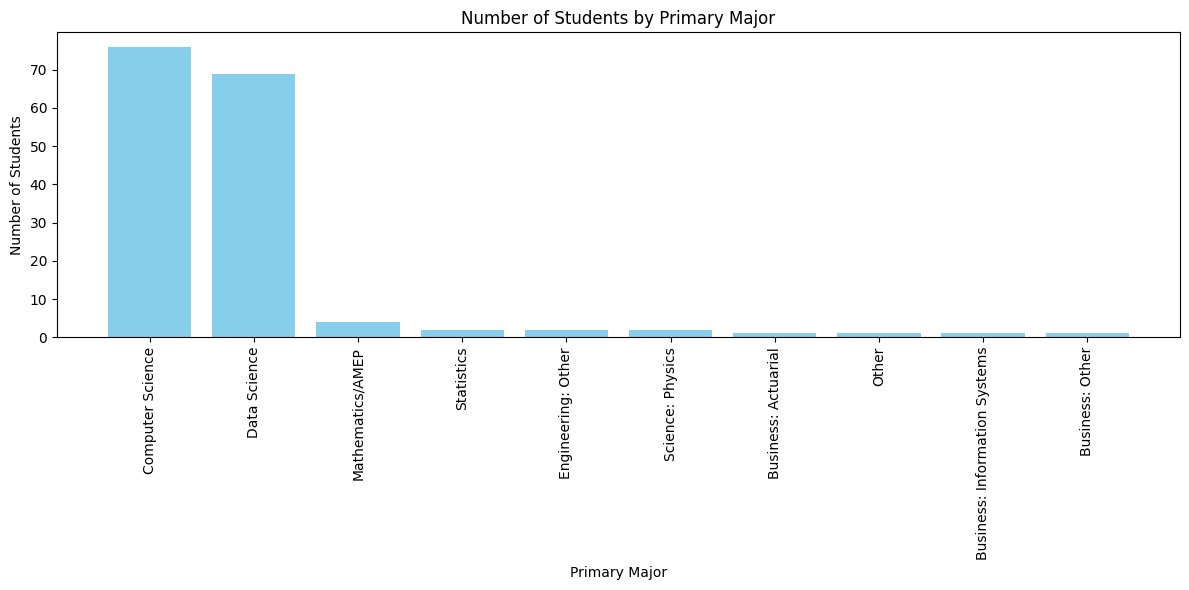

In [28]:
# Sort the DataFrame by No_of_students in descending order
df_sorted = df.sort_values(by='NO_OF_STUDENTS', ascending=False)

# Plot
plt.figure(figsize=(12, 6))
plt.bar(df_sorted['PRIMARY_MAJOR'], df_sorted['NO_OF_STUDENTS'], color='skyblue')

# Rotate major names to be completely vertical
plt.xticks(rotation=90)

# Add labels and title
plt.xlabel('Primary Major')
plt.ylabel('Number of Students')
plt.title('Number of Students by Primary Major')
plt.tight_layout()  # Adjust layout to avoid label clipping

plt.show()

#### Q12: % of student with same interest to pursue CS639? Also plot relevant graph to show this?

In [36]:
df = pd.read_sql("""
SELECT COURSE_INFLUENCE, ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM TRANSFORM_SURVEY),1) AS Percent_of_Student
FROM TRANSFORM_SURVEY
GROUP BY COURSE_INFLUENCE
ORDER BY Percent_of_Student DESC
""", conn)
df

/tmp/ipykernel_1873960/3682185016.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("""


,COURSE_INFLUENCE,PERCENT_OF_STUDENT
0,Interest in the subject,51.6
1,Career relevance,25.8
2,Graduation requirements,15.1
3,Instructor reputation,3.8
4,Course workload,3.8


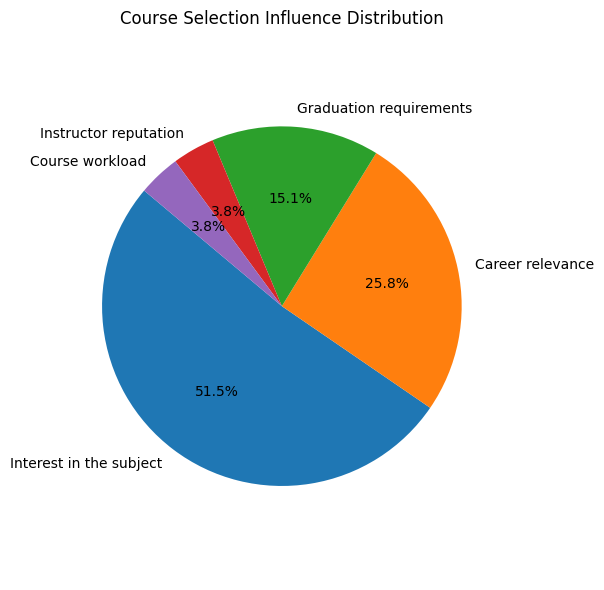

In [37]:
import matplotlib.pyplot as plt

# Ensure the data is sorted if needed
df_sorted = df.sort_values(by='PERCENT_OF_STUDENT', ascending=False)

# Pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    df_sorted['PERCENT_OF_STUDENT'],
    labels=df_sorted['COURSE_INFLUENCE'],
    autopct='%1.1f%%',
    startangle=140,
    textprops={'fontsize': 10}
)

# Title and layout
plt.title('Course Selection Influence Distribution')
plt.axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle
plt.tight_layout()
plt.show()

#### Q13: % of Students having Secondary Major

In [39]:
df = pd.read_sql("""
SELECT ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM TRANSFORM_SURVEY),1) AS Percentage_of_student
FROM TRANSFORM_SURVEY
WHERE SECONDARY_MAJOR IS NOT NULL
OR SECONDARY_MAJOR <> 'N/A'
""", conn)
df

/tmp/ipykernel_1873960/3717057993.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("""


,PERCENTAGE_OF_STUDENT
0,41.5


#### Q14: Top 3 things student do with their extra hour

In [41]:
df = pd.read_sql("""
WITH ranking AS
(
SELECT 
EXTRA_HOUR,
COUNT(*) as no_of_student,
DENSE_RANK() OVER(ORDER BY COUNT(*) DESC) as d_rank
FROM TRANSFORM_SURVEY
GROUP BY EXTRA_HOUR
)
SELECT *
FROM ranking
WHERE d_rank <= 3
""", conn)
df

/tmp/ipykernel_1873960/1164430563.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("""


,EXTRA_HOUR,NO_OF_STUDENT,D_RANK
0,Working on a hobby,44,1
1,Sleeping,43,2
2,Exercising,33,3


#### Q15: Since CS639 is not a graduate course (As not 700 level). What fraction of students are graduate students? 

In [42]:
df = pd.read_sql("""
SELECT ROUND(COUNT(*) * 1.0 / (SELECT COUNT(*) FROM TRANSFORM_SURVEY),2) as grad_percent
FROM TRANSFORM_SURVEY
WHERE ACADEMIC_STANDING = 'Grad'
""", conn)
df

/tmp/ipykernel_1873960/2156890179.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("""


,GRAD_PERCENT
0,0.12


Validates that only 12% of students are graduate students as the course is not 700 level

#### Q16: How many students are categorized in each sleep type? Order the output from highest to lowest

In [44]:
df = pd.read_sql("""
SELECT SLEEP_TYPE, COUNT(*) AS no_of_student
FROM TRANSFORM_SURVEY
GROUP BY SLEEP_TYPE
ORDER BY no_of_student DESC
""", conn)
df

/tmp/ipykernel_1873960/2010510056.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("""


,SLEEP_TYPE,NO_OF_STUDENT
0,night owl,101
1,early bird,33
2,no preference,25


#### Q18: Configure `~/.dbt/profiles.yml` for `STOCK_DB` (0.5 points)

In [6]:
!cat ~/.dbt/profiles.yml | grep -v password

p4_data_pipeline:
  target: dev
  outputs:
    dev:
      type: snowflake
      account: TQ19230.us-central1.gcp
      user: YCHAUDHARI
      role: P4_ROLE
      database: SURVEY_DATABASE
      warehouse: P4_WAREHOUSE
      schema: SURVEY_SCHEMA
      threads: 1
      client_session_keep_alive: False

  target: stock_db
  outputs:
    stock_db:
      type: snowflake
      account: TQ19230.us-central1.gcp
      user: YCHAUDHARI
      role: P4_ROLE
      database: STOCK_DB
      warehouse: P4_WAREHOUSE
      schema: STOCK_SCHEMA
      threads: 1
      client_session_keep_alive: false


#### Q19: Update `models/schema.yml` file to include new sources for `STOCK_DB` tables (0.5 points)

In [7]:
!cat ../p4_data_pipeline/models/schema.yml

version: 2

sources:
  - name: p4_survey_data
    database: SURVEY_DATABASE
    schema: SURVEY_SCHEMA
    tables:
      - name: survey  # original table from Google Sheets

  - name: stock_by_day
    database: STOCK_DB
    schema: STOCK_SCHEMA
    tables:
      - name: US_STOCK_METRICS

  - name: fx_by_day
    database: STOCK_DB
    schema: STOCK_SCHEMA
    tables:
      - name: FOREX_METRICS

  - name: airbyte_csv_data
    database: STOCK_DB
    schema: STOCK_SCHEMA
    tables:
      - name: TRADING_BOOKS
      - name: WEIGHTS_TABLE


#### Q20: Create `dbt_project.yml` file in your dbt project directory --- `p4_data_pipeline` (0.5 points)

In [50]:
!cat ../p4_data_pipeline/dbt_project.yml


# Name your project! Project names should contain only lowercase characters
# and underscores. A good package name should reflect your organization's
# name or the intended use of these models
name: 'p4_data_pipeline'
version: '1.0.0'

# This setting configures which "profile" dbt uses for this project.
profile: 'p4_data_pipeline'

# These configurations specify where dbt should look for different types of files.
# The `model-paths` config, for example, states that models in this project can be
# found in the "models/" directory. You probably won't need to change these!
model-paths: ["models"]
analysis-paths: ["analyses"]
test-paths: ["tests"]
seed-paths: ["seeds"]
macro-paths: ["macros"]
snapshot-paths: ["snapshots"]

clean-targets:         # directories to be removed by `dbt clean`
  - "target"
  - "dbt_packages"


# Configuring models
# Full documentation: https://docs.getdbt.com/docs/configuring-models

# In this example config, we tell dbt to build all models in the example/
# di

#### Q21: Creating staging tables for FX and Stock (1 point)

In [51]:
!cat ../p4_data_pipeline/models/staging/staging_valid_fx_tickers.sql

with trading_books as (
    select * from {{ source('airbyte_csv_data', 'TRADING_BOOKS') }}
)

select distinct
    ticker,
    trade_date
from trading_books
where desk = 'FX Desk'


In [52]:
!cat ../p4_data_pipeline/models/staging/staging_valid_stock_tickers.sql

with trading_books as (
    select * from {{ source('airbyte_csv_data', 'TRADING_BOOKS') }}
)

select distinct
    ticker,
    trade_date
from trading_books
where desk = 'Equity Desk'


In [53]:
!cat ../p4_data_pipeline/models/staging/staging_valid_stock_info.sql

with valid_tickers as (
    select * from {{ ref('staging_valid_stock_tickers') }}
),
stock_data as (
    select * from {{ source('stock_by_day', 'US_STOCK_METRICS') }}
)

select
    s.ticker,
    s.run_date,
    s.open,
    s.close,
    s.high,
    s.low
from stock_data s
join valid_tickers v
on s.ticker = v.ticker and s.run_date = v.trade_date


In [54]:
!cat ../p4_data_pipeline/models/staging/staging_valid_fx_info.sql

with valid_tickers as (
    select * from {{ ref('staging_valid_fx_tickers') }}
),
fx_data as (
    select * from {{ source('fx_by_day', 'FOREX_METRICS') }}
)

select
    f.currency_pair_name as ticker,
    f.run_date,
    f.open,
    f.close,
    f.high,
    f.low
from fx_data f
join valid_tickers v
on f.currency_pair_name = v.ticker and f.run_date = v.trade_date


In [57]:
cursor.execute("USE DATABASE STOCK_DB;")
cursor.execute("USE SCHEMA STOCK_SCHEMA;")

df1 = pd.read_sql("SELECT * FROM staging_valid_fx_tickers", conn)
df2 = pd.read_sql("SELECT * FROM staging_valid_stock_tickers", conn)
df3 = pd.read_sql("SELECT * FROM staging_valid_stock_info", conn)
df4 = pd.read_sql("SELECT * FROM staging_valid_fx_info", conn)

df1.to_csv("files/staging_valid_fx_tickers.csv", index=False)
df2.to_csv("files/staging_valid_stock_tickers.csv", index=False)
df3.to_csv("files/staging_valid_stock_info.csv", index=False)
df4.to_csv("files/staging_valid_fx_info.csv", index=False)

/tmp/ipykernel_1873960/2815257297.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df1 = pd.read_sql("SELECT * FROM staging_valid_fx_tickers", conn)
/tmp/ipykernel_1873960/2815257297.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df2 = pd.read_sql("SELECT * FROM staging_valid_stock_tickers", conn)
/tmp/ipykernel_1873960/2815257297.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df3 = pd.read_sql("SELECT * FROM staging_valid_stock_info", conn)
/tmp/ipykernel_1873960/2815257297.py:7: UserWarning: pandas only suppo

#### Q22: Create staging table for trading pairs (0.5 points)

In [58]:
!cat ../p4_data_pipeline/models/staging/staging_buy_sell_joint.sql

with buy_trades as (
    select
        TRADE_ID as buy_trade_id,
        TRADE_DATE,
        TRADER_NAME,
        DESK,
        TICKER,
        QUANTITY as quantity_buy,
        PRICE as price_buy
    from {{ source('airbyte_csv_data', 'TRADING_BOOKS') }}
    where TRADE_TYPE = 'BUY'
),

sell_trades as (
    select
        TRADE_DATE,
        TRADER_NAME,
        TICKER,
        QUANTITY as quantity_sell,
        PRICE as price_sell
    from {{ source('airbyte_csv_data', 'TRADING_BOOKS') }}
    where TRADE_TYPE = 'SELL'
)

select
    b.buy_trade_id,
    b.trade_date,
    b.trader_name,
    b.desk,
    b.ticker,
    b.quantity_buy,
    b.price_buy,
    s.quantity_sell,
    s.price_sell
from buy_trades b
join sell_trades s
on b.trader_name = s.trader_name
   and b.trade_date = s.trade_date
   and b.ticker = s.ticker
order by b.buy_trade_id


In [59]:
df = pd.read_sql("SELECT * FROM staging_buy_sell_joint", conn)
df.to_csv("files/staging_buy_sell_joint.csv", index=False)

/tmp/ipykernel_1873960/119166076.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT * FROM staging_buy_sell_joint", conn)


#### Q23: Create a fact Table for trading data (1.5 points)

In [60]:
!cat ../p4_data_pipeline/models/marts/fact_tab_trading.sql

{{ config(
    materialized='table'
) }}

with base as (
    select
        buy_trade_id,
        quantity_buy,
        price_buy,
        quantity_sell,
        price_sell
    from {{ ref('staging_buy_sell_joint') }}
)

select
    buy_trade_id,
    quantity_buy * price_buy as buy_money,
    quantity_sell * price_sell as sell_money,
    (quantity_sell * price_sell) - (quantity_buy * price_buy) as profit
from base
order by buy_trade_id


In [61]:
df.to_csv('files/fact_tab_trading.csv', index=False)

#### Q24: Compute total profit by desk (1 point)

In [63]:
df = pd.read_sql(
    '''SELECT
      t.desk,
      SUM(f.profit) AS total_profit
    FROM STOCK_DB.STOCK_SCHEMA.FACT_TAB_TRADING f
    JOIN STOCK_DB.STOCK_SCHEMA.TRADING_BOOKS t
    ON f.buy_trade_id = t.trade_id
    WHERE t.trade_type = 'BUY'
    GROUP BY t.desk
    ORDER BY t.desk;''', conn)
df

/tmp/ipykernel_1873960/2713558185.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(


,DESK,TOTAL_PROFIT
0,Equity Desk,2718.75
1,FX Desk,5000.00


#### Q25: Compute profit rate by desk (1 point)

In [64]:
df = pd.read_sql(
    '''
    SELECT
      t.desk,
      SUM(f.profit) / NULLIF(SUM(f.buy_money), 0) AS profit_rate
    FROM STOCK_DB.STOCK_SCHEMA.FACT_TAB_TRADING f
    JOIN STOCK_DB.STOCK_SCHEMA.TRADING_BOOKS t 
    ON f.buy_trade_id = t.trade_id
    WHERE t.trade_type = 'BUY'
    GROUP BY t.desk
    ORDER BY t.desk;
    ''', conn)
df

/tmp/ipykernel_1873960/2445783942.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(


,DESK,PROFIT_RATE
0,Equity Desk,0.012701
1,FX Desk,0.006342
